In [87]:
# import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

In [88]:
nyt_county_df = pd.read_csv('./query_result/nytimes_data_in_usa_us_county_results.csv')
nyt_county_df.head()

,date,county,state,fips,cases,deaths
0,2021-12-30,Catahoula,Louisiana,22025.0,1879,48.0
1,2021-12-30,Claiborne,Louisiana,22027.0,2138,66.0
2,2021-12-30,Concordia,Louisiana,22029.0,3402,80.0
3,2021-12-30,De Soto,Louisiana,22031.0,5107,115.0
4,2021-12-30,East Baton Rouge,Louisiana,22033.0,70112,1180.0


In [89]:
nyt_county_df.head()

,date,county,state,fips,cases,deaths
0,2021-12-30,Catahoula,Louisiana,22025.0,1879,48.0
1,2021-12-30,Claiborne,Louisiana,22027.0,2138,66.0
2,2021-12-30,Concordia,Louisiana,22029.0,3402,80.0
3,2021-12-30,De Soto,Louisiana,22031.0,5107,115.0
4,2021-12-30,East Baton Rouge,Louisiana,22033.0,70112,1180.0


In [90]:
import matplotlib.pyplot as plt

SARIMAX

In [91]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [92]:
nyt_county_df['date'] = pd.to_datetime(nyt_county_df['date'])

# Separate cases and deaths data
cases_df = nyt_county_df[['date', 'cases']].groupby('date').sum().reset_index()
deaths_df = nyt_county_df[['date', 'deaths']].groupby('date').sum().reset_index()

In [93]:

# Fit SARIMAX models for cases and deaths separately
cases_model = SARIMAX(cases_df['cases'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)).fit()
deaths_model = SARIMAX(deaths_df['deaths'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)).fit()

# Forecast future cases and deaths
cases_forecast = cases_model.forecast(steps=30)
deaths_forecast = deaths_model.forecast(steps=30)


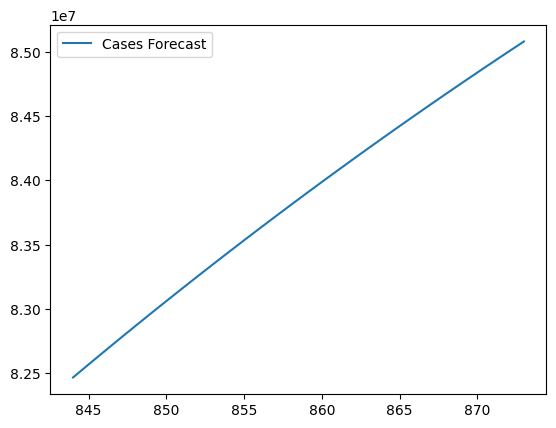

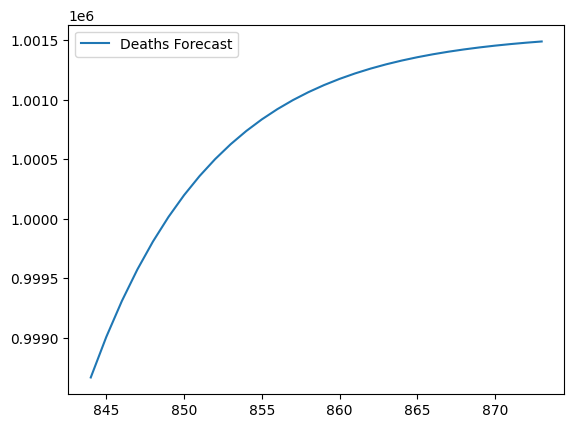

In [94]:
# Plot the forecasts for cases
plt.plot(cases_forecast, label='Cases Forecast')
plt.legend()
plt.show()

# Plot the forecasts for deaths
plt.plot(deaths_forecast, label='Deaths Forecast')
plt.legend()
plt.show()

In [95]:
from sklearn.metrics import mean_squared_error


In [96]:
cases_df.head()

,date,cases
0,2020-01-21,1
1,2020-01-22,1
2,2020-01-23,1
3,2020-01-24,2
4,2020-01-25,3


In [97]:
# Calculate and print accuracy metrics
cases_actual = cases_df['cases'][-30:]
deaths_actual = deaths_df['deaths'][-30:]
cases_mse = mean_squared_error(cases_actual, cases_forecast)
deaths_mse = mean_squared_error(deaths_actual, deaths_forecast)
cases_rmse = round(cases_mse**0.5, 2)
deaths_rmse = round(deaths_mse**0.5, 2)
print(f"Cases RMSE: {cases_rmse}")
print(f"Deaths RMSE: {deaths_rmse}")

Cases RMSE: 2597739.49
Deaths RMSE: 9231.89


In [98]:
cases_actual.head()

814    80466106
815    80513724
816    80524627
817    80535906
818    80595982
Name: cases, dtype: int64

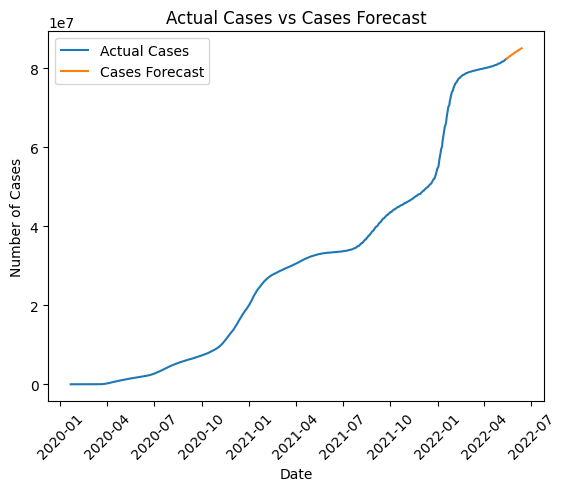

In [99]:
# Plot actual cases
plt.plot(cases_df['date'], cases_df['cases'], label='Actual Cases')

# Plot forecasted cases
forecast_dates = pd.date_range(start=cases_df['date'].iloc[-1], periods=len(cases_forecast)+1, freq='D')[1:]
plt.plot(forecast_dates, cases_forecast, label='Cases Forecast')

# Set plot title and labels
plt.title('Actual Cases vs Cases Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.xticks(rotation=45)
# Display plot
plt.show()

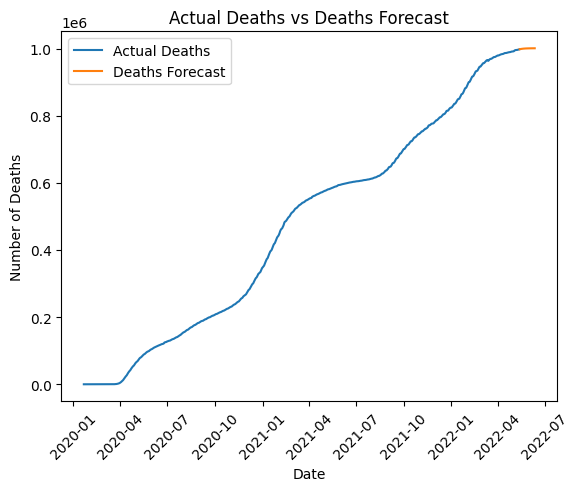

In [100]:
# Plot actual cases
plt.plot(deaths_df['date'], deaths_df['deaths'], label='Actual Deaths')

# Plot forecasted cases
forecast_dates = pd.date_range(start=deaths_df['date'].iloc[-1], periods=len(deaths_forecast)+1, freq='D')[1:]
plt.plot(forecast_dates, deaths_forecast, label='Deaths Forecast')

# Set plot title and labels
plt.title('Actual Deaths vs Deaths Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.legend()
plt.xticks(rotation=45)
# Display plot
plt.show()

### LSTM

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [102]:
nyt_county_df.head()

,date,county,state,fips,cases,deaths
0,2021-12-30,Catahoula,Louisiana,22025.0,1879,48.0
1,2021-12-30,Claiborne,Louisiana,22027.0,2138,66.0
2,2021-12-30,Concordia,Louisiana,22029.0,3402,80.0
3,2021-12-30,De Soto,Louisiana,22031.0,5107,115.0
4,2021-12-30,East Baton Rouge,Louisiana,22033.0,70112,1180.0


In [103]:
lstm_df = nyt_county_df[['date', 'cases', 'deaths']].groupby('date').sum().reset_index()
lstm_df.head()

,date,cases,deaths
0,2020-01-21,1,0.0
1,2020-01-22,1,0.0
2,2020-01-23,1,0.0
3,2020-01-24,2,0.0
4,2020-01-25,3,0.0


In [104]:
lstm_df['deaths'] = lstm_df['deaths'].apply(np.int64)

In [105]:
data = lstm_df['cases'].values.reshape(-1,1)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [106]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [107]:
# Define the input-output sequence
n_steps = 18 # number of previous time steps to use as input
X, y = [], []
for i in range(n_steps, len(data)):
    X.append(data[i-n_steps:i, 0])
    y.append(data[i, 0])
X, y = np.array(X), np.array(y)

# Split the data
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model.fit(X_train, y_train, epochs=100, verbose=1)

# Evaluate the LSTM model
mse = model.evaluate(X_test, y_test, verbose=0)
print('MSE:', mse)

Epoch 1/100
22/22 [==============================] - 2s 9ms/step - loss: 0.0804
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0201
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 5.1219e-04
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 1.6918e-04
Epoch 5/100
22/22 [==============================] - 0s 9ms/step - loss: 6.2641e-05
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 3.5629e-05
Epoch 7/100
22/22 [==============================] - 0s 9ms/step - loss: 1.9136e-05
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 1.2396e-05
Epoch 9/100
22/22 [==============================] - 0s 7ms/step - loss: 8.4529e-06
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 6.5849e-06
Epoch 11/100
22/22 [==============================] - 0s 6ms/step - loss: 6.0611e-06
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 5.6372e-

1/1 [==============================] - 0s 24ms/step


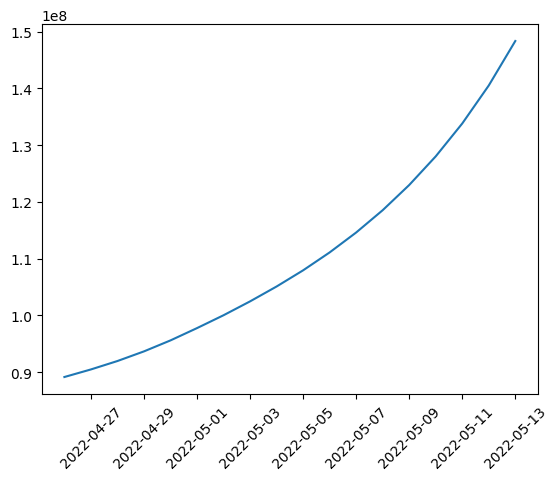

In [108]:
# Make predictions
n_future = 18 # number of future time steps to predict
forecast = data[-n_steps:].reshape((1, n_steps, 1))
for i in range(n_future):
    y_pred = model.predict(forecast)
    forecast = np.append(forecast[:,1:,:], y_pred.reshape((1,1,1)), axis=1)

# Inverse transform the predicted values
forecast = scaler.inverse_transform(forecast.reshape(-1,1))

# Plot the predicted values
import matplotlib.pyplot as plt
plt.plot(lstm_df['date'][-n_future:], forecast[-n_future:])
plt.xticks(rotation=45)
plt.show()

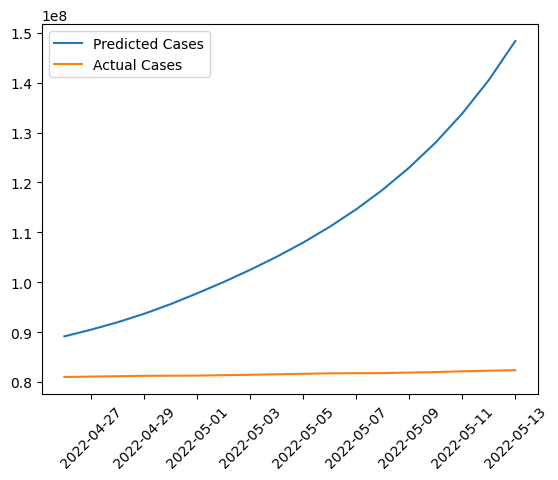

In [109]:
# Create a new dataframe with predicted and actual values
pred_df = pd.DataFrame({'date': lstm_df['date'][-n_future:],
                        'predicted_cases': forecast[-n_future:].flatten(),
                        'actual_cases': lstm_df['cases'][-n_future:].values})

# Plot the predicted and actual values
plt.plot(pred_df['date'], pred_df['predicted_cases'], label='Predicted Cases')
plt.plot(pred_df['date'], pred_df['actual_cases'], label='Actual Cases')
plt.legend()
plt.xticks(rotation=45)
plt.show()